In [1]:
%matplotlib inline

from shared_content import *

In [12]:
# Do you want to write figures to png files? Careful, it will overwrite!
write_figures = True
figdir = 'Figures/'

In [3]:
filedir = 'anafiles/'

anatype = 'MCBNBRecoTrack'


In [4]:
df_dict, segdf_dict = {}, {}
reses = [ 0, 1, 2, 3, 5, 10 ]
for seglen in reses:
    myfile = 'MCSBiasStudy_%s_anaout_10cmseg_%dres_bothscatters_nonrelfix.root' %( anatype, seglen )
    df_dict[seglen], segdf_dict[seglen] = get_dfs(filedir + myfile)

In [5]:
def basic_comparison_fig(xvar, yvar, plotname =None, extraquery = None, addtext = None, seglen = 10, myres = 2):
    plt.figure(figsize=(10,6)) 
    mydf = df_dict[myres]
    myquery = 'true_E < 99999999'
    if extraquery is not None: myquery += ' and %s'%extraquery
    myx = mydf.query(myquery)[xvar].values
    myy = mydf.query(myquery)[yvar].values
    blah = plt.hist2d(myx,myy,bins=((np.linspace(0,2,50),np.linspace(0,2,50))),cmin=1)
    blah = plt.colorbar()
    blah = plt.grid(True)
    blha = plt.xlabel('%s'%titles[xvar],fontsize=16)
    blha = plt.ylabel('%s'%titles[yvar],fontsize=16)
    blha = plt.title('%s'%(titles[anatype]),fontsize=16)
    blha.set_y(1.04)
    blah = plt.plot([0,100],[0,100],'g--',linewidth=3)
    
    if addtext is not None:
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1]*0.1, addtext, fontsize=20)
     
    plt.text(plt.xlim()[1]*0.5, plt.ylim()[1]*0.1, '%d mrad Resolution' % myres,fontsize=20)
    
    if write_figures:
        if plotname is not None: 
            print "Saving figure %s"%plotname
            plt.tight_layout()
            plt.savefig(figdir + plotname)
        else: print "YOU WANTED TO SAVE A PLOT BUT DIDN'T GIVE A PLOT NAME!"


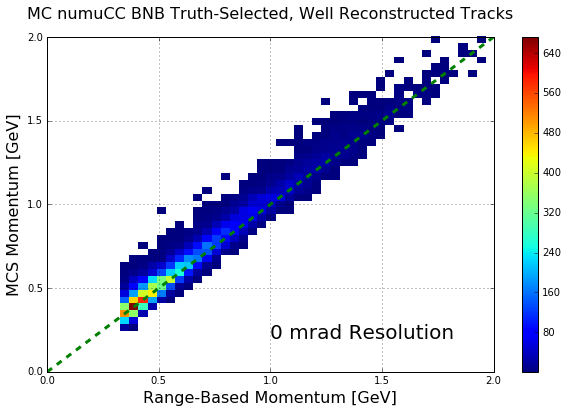

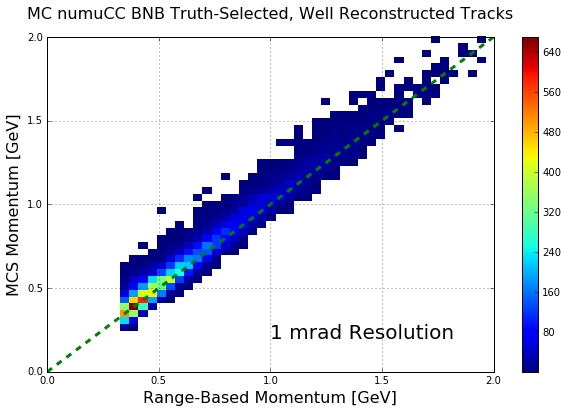

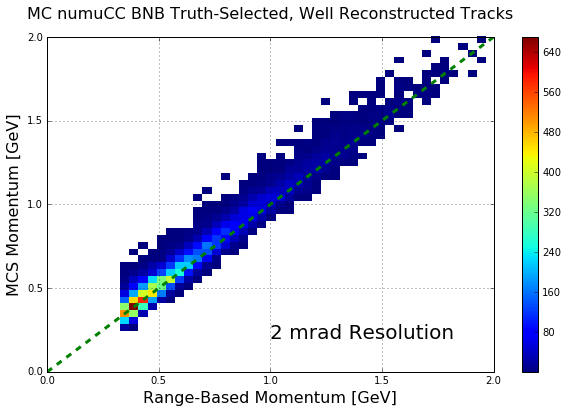

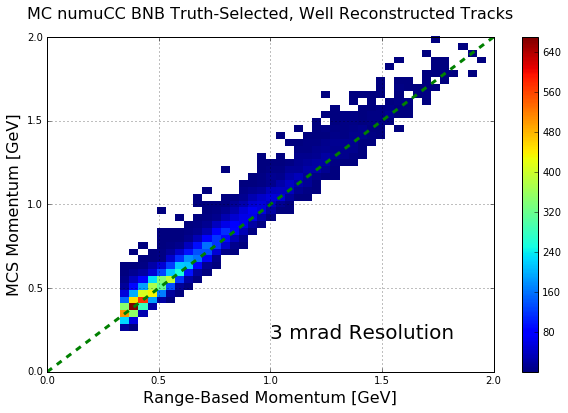

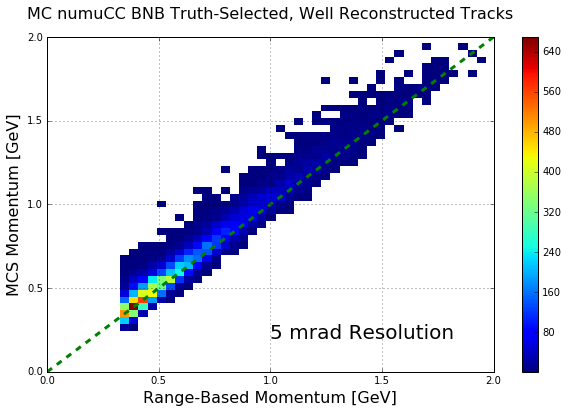

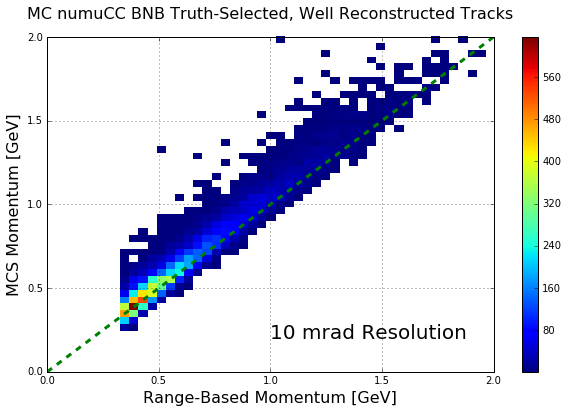

In [6]:
for res in reses:
    
    basic_comparison_fig(xvar='full_range_momentum',yvar='full_MCS_momentum',
                         plotname=None, seglen=10, myres = res)

In [7]:
def highlandE(rms):
    loverX = float(seglen)/14.
    return np.sqrt((13.6*13.6*loverX*np.square((1+0.038*np.log(loverX))))/np.square(rms))

In [9]:
#reco-true/true
def fractional_bias_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for res in reses:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[res].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:
                #plt.figure(figsize=(5,3))
                datahist = np.histogram((reco-true)/true,bins=slicebins)
                #titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
                #(latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax)
                #t =plt.title(titlestring,fontsize=16)
                #move the title up a bit
                #t.set_y(1.04) 
                #plt.grid(False)
                
                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                    #plt.plot(thisx, thisy, 'g-',\
                    #     label='Gaus Fit',\
                    #     linewidth=2)
                    #addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                    #(np.abs(result.params['wid']),result.params['cen'])
                    #plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                    
                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
                        
                 
                    
                    
                #plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
                #plt.ylabel('Counts',fontsize=16)
                #plt.xlim((np.min(slicebins),np.max(slicebins)))
                #plt.legend(loc=1)
                #if write_figures and slicetitlebase is not None:
                #    fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                #    print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                #    plt.tight_layout()
                #    plt.savefig(fullfigname)
            
            
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #BIAS PLOT    
        plt.errorbar(bincenters[:-1],myreses,yerr=myerrs_bias,xerr=binwidth/2,fmt='o',label='Resolution: %d mrad'%res)
    plt.ylabel('GausMean($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Bias: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)
    if biasmainfig_ylims is not None:
        blah = plt.ylim(biasmainfig_ylims)
    if write_figures and biasplotname is not None:
        print " \n\n Writing the main bias figure!! %s\n\n" % (figdir+biasplotname)
        plt.tight_layout()
        plt.savefig(figdir + biasplotname)

In [14]:
#reco-true/true
def fractional_resolution_plot(xvar = 'full_range_momentum', xbins = np.linspace(0.35,1,10),
                   yvar = 'full_MCS_momentum', slicevar = 'full_range_momentum',
                         plot_bin_distributions = False, extraquery = None, slicetitlebase = None,
                        slicebins = np.linspace(-0.8,.8,20),
                        biasplotname = None, resplotname = None, biasmainfig_ylims = None,
                         resmainfig_ylims = None,
                        usegausfit = False):
    plt.figure(figsize=(10,6))
    binning = xbins
    binwidth = float(binning[1]-binning[0])
    bincenters = binning + (binwidth/2)

    for res in reses:
        
        myreses, mystds, myerrs_bias, myerrs_res = [], [], [], []
    
        for x in xrange(len(binning)-1):
            
            binmin = binning[x]
            binmax = binning[x+1]
            #print "binmin = %0.2f, binmax = %0.2f"% ( binmin, binmax )
            myquery = '%s > %f and %s < %f'%(slicevar,binmin,slicevar,binmax)
            if anatype == 'DataBNBSelectedRecoTrack': 
                myquery += ' and not maybe_bad'
            if extraquery is not None:
                myquery += ' and %s' % extraquery
                
            mydf = df_dict[res].query(myquery)
            true = mydf[xvar].values
            reco = mydf[yvar].values
            mymean = ((reco-true)/true).mean()
            mystd = ((reco-true)/true).std()
            
            if plot_bin_distributions:
                #plt.figure(figsize=(5,3))
                datahist = np.histogram((reco-true)/true,bins=slicebins)
                #titlestring = '$\\frac{%s - %s}{%s}$ for $%s$ in %0.2f $\\rightarrow$ %0.2f GeV'% \
                #(latextitles[yvar],latextitles[xvar],latextitles[xvar],latextitles[slicevar],binmin,binmax)
                #t =plt.title(titlestring,fontsize=16)
                #move the title up a bit
                #t.set_y(1.04) 
                #plt.grid(False)
                
                # Plot gaussian on each bin distribution
                if usegausfit:
                     
                    slicebinvals = datahist[0]
                    slicebincenters = [ datahist[1][x] + (datahist[1][x+1]-datahist[1][x])/2 for x in xrange(len(datahist[1])-1) ]
        
                    # Fit a normal distribution
                    gmod = Model(gaussian)
                    #initial random guesses of 1, 1, 2
                    result = gmod.fit(slicebinvals, x=slicebincenters, amp=1, cen=1, wid=2)
    
                    thisx = np.linspace(np.min(slicebins),np.max(slicebins),100)
                    thisy = gaussian(thisx, result.params['amp'], result.params['cen'], result.params['wid'])
                    #plt.plot(thisx, thisy, 'g-',\
                    #     label='Gaus Fit',\
                    #     linewidth=2)
                    #addtext = 'Fit: \n$\sigma$ = %0.2f, \n$\mu$ = %0.2f'%\
                    #(np.abs(result.params['wid']),result.params['cen'])
                    #plt.text(plt.xlim()[1]*0.35, plt.ylim()[1]*0.1, addtext, fontsize=14)
                    
                    # If use gaus fit, use the result of that instead of straight mean and RMS
                    mymean = result.params['cen']
                    #Somehow when there are like 2 data points you get a negative width?!
                    mystd  = np.abs(result.params['wid'])
                    # If the fit doesn't converge, 'wid' will be the initial guess of 2.0... don't use these points then
                    # (this only happens when no entries in the sliced histogram)
                    if int(result.params['wid']) == 2:
                        print "WARNING: FIT DIDN'T CONVERGE!"
                        mymean = ((reco-true)/true).mean()
                        mystd = ((reco-true)/true).std()
                        
                 
                    
                    
                #plt.xlabel('$\\frac{%s - %s}{%s}$'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=16)
                #plt.ylabel('Counts',fontsize=16)
                #plt.xlim((np.min(slicebins),np.max(slicebins)))
                #plt.legend(loc=1)
                #if write_figures and slicetitlebase is not None:
                #    fullfigname = figdir + slicetitlebase + '_slice_%0.2f_%0.2f.png'%(binmin,binmax)
                #    print '\n\n WRITING A FIGURE!! %s\n\n'%fullfigname
                #    plt.tight_layout()
                #    plt.savefig(fullfigname)
            
            
            myerr_bias = mystd / np.sqrt( float(len(true)) )
            myerr_res = mystd / np.sqrt( float(2*len(true)) )
            myreses.append( mymean )
            mystds.append( mystd )
            myerrs_bias.append( myerr_bias )
            myerrs_res.append( myerr_res )
            
            
        #RESOLUTION PLOT    
        plt.errorbar(bincenters[:-1],mystds,yerr=myerrs_bias,xerr=binwidth/2,fmt='o',label='Resolution: %d mrad' % res)
    plt.ylabel('GausWidth($\\frac{%s - %s}{%s}$)'%(latextitles[yvar],latextitles[xvar],latextitles[xvar]),fontsize=25)
    plt.xlabel('%s'%titles[slicevar],fontsize=15)
    plt.grid(True)
    plt.legend(loc='best')
    t = plt.title('Fractional Momentum Resolution: %s'%titles[anatype],fontsize=16)
    t.set_y(1.04)
    if resmainfig_ylims is not None:
        blah = plt.ylim(resmainfig_ylims)
    if write_figures and resplotname is not None:
        print " \n\n Writing the main res figure!! %s\n\n" % (figdir+resplotname)
        plt.tight_layout()
        plt.savefig(figdir + resplotname)

 

 Writing the main bias figure!! Figures/resstudy_MCBNBRecoTrack_bias.png


 

 Writing the main res figure!! Figures/resstudy_MCBNBRecoTrack_resolution.png




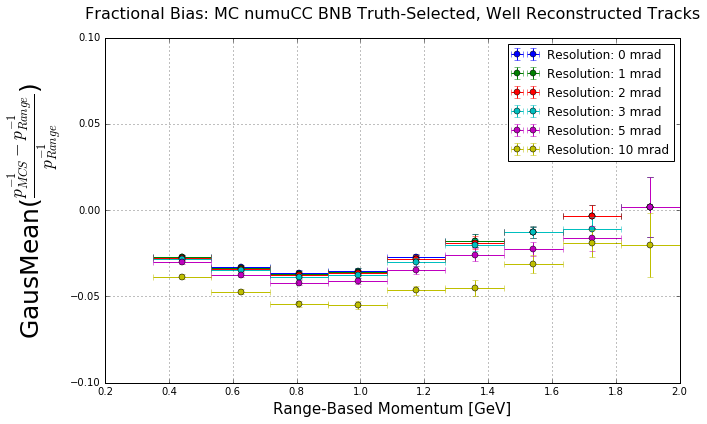

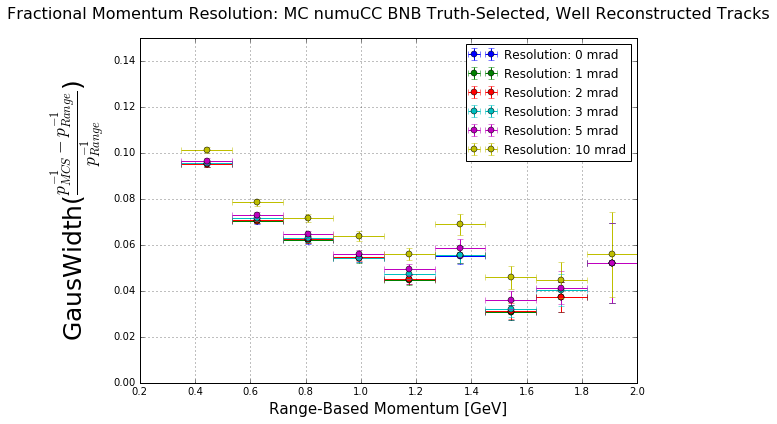

In [15]:
fractional_bias_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       biasplotname = 'resstudy_%s_bias.png'%anatype,
                       biasmainfig_ylims = (-.10,.10),
                        usegausfit = True)

fractional_resolution_plot(xvar='full_range_momentum_inverse',yvar='full_MCS_momentum_inverse',
                     xbins=np.linspace(0.35,2,10),
                       plot_bin_distributions = True,
                       slicevar = 'full_range_momentum',
                       slicetitlebase = None,
                       slicebins = np.linspace(-0.8,0.8,50),
                       resplotname = 'resstudy_%s_resolution.png'%anatype,
                       resmainfig_ylims = (0,.15),
                        usegausfit = True)